In [24]:
import pandas as pd
import numpy as np
import os
import sys
from datetime import datetime
import matplotlib.pyplot as plt
import sqlite3
from tqdm import tqdm
import pickle
import time 

from datetime import datetime
from datetime import timedelta

from SQLite_tools import query_stock_data, check_if_close_price_exists
from ticker_loader import load_SPY_components

import matplotlib.pyplot as plt
import pandas as pd
import pickle
from tqdm.notebook import tqdm
import xgboost as xgb
import shap
from sklearn.metrics import mean_squared_error

In [2]:
# train_df = query_stock_data(table = "ML_Feature_Table", ticker = "all_stocks", start_date="2020-05-08", end_date="2022-01-07")
train_df = query_stock_data(table = "ML_Feature_Table", ticker = "all_stocks", start_date="1996-04-08", end_date="2016-01-07")
# val_df   = query_stock_data(table = "ML_Feature_Table", ticker = "all_stocks", start_date="2023-07-08", end_date="2023-10-31")
val_df   = query_stock_data(table = "ML_Feature_Table", ticker = "all_stocks", start_date="2016-01-08", end_date="2018-10-31")
# test_df  = query_stock_data(table = "ML_Feature_Table", ticker = "all_stocks", start_date="2024-02-01", end_date="2024-07-01")
test_df  = query_stock_data(table = "ML_Feature_Table", ticker = "all_stocks", start_date="2018-11-01", end_date="2024-07-01")
train_df

,Date,Ticker,Open,High,Low,Close,EPSActual,EPSDifference,Relative_TotalRevenue,Relative_GrossProfit,...,Financial_Services,Financials,Healthcare,Industrial_Goods,Industrials,Other,Real_Estate,Services,Technology,Utilities
0,1996-04-08,RCL,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1996-04-08,WAT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1996-04-08,AEE,-0.497079,-0.345274,-1.256102,-0.952493,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1996-04-08,GRA,-1.077575,-0.519714,-1.316583,-0.519714,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1996-04-08,TRGP,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3666905,2016-01-07,BCR,-0.097314,0.138296,-0.428766,0.010507,0.000000,0.000000,0.150002,-0.062514,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3666906,2016-01-07,KR,-0.648577,-0.482555,-1.041786,-0.875764,-0.007889,0.022603,-0.162913,0.040117,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3666907,2016-01-07,CL,-0.443350,-0.156921,-0.809981,-0.666766,0.012651,0.019781,-0.154383,-0.060871,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3666908,2016-01-07,DNR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
train_df

,Date,Ticker,Open,High,Low,Close,EPSActual,EPSDifference,Relative_TotalRevenue,Relative_GrossProfit,...,Financial_Services,Financials,Healthcare,Industrial_Goods,Industrials,Other,Real_Estate,Services,Technology,Utilities
0,1996-04-08,RCL,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1996-04-08,WAT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1996-04-08,AEE,-0.497079,-0.345274,-1.256102,-0.952493,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1996-04-08,GRA,-1.077575,-0.519714,-1.316583,-0.519714,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1996-04-08,TRGP,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3666905,2016-01-07,BCR,-0.097314,0.138296,-0.428766,0.010507,0.000000,0.000000,0.150002,-0.062514,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3666906,2016-01-07,KR,-0.648577,-0.482555,-1.041786,-0.875764,-0.007889,0.022603,-0.162913,0.040117,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3666907,2016-01-07,CL,-0.443350,-0.156921,-0.809981,-0.666766,0.012651,0.019781,-0.154383,-0.060871,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3666908,2016-01-07,DNR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# train_target = query_stock_data(table = "Target_Data", ticker = "all_stocks", start_date="2020-05-08", end_date="2022-01-07")
train_target = query_stock_data(table = "Target_Data", ticker = "all_stocks", start_date="1996-04-08", end_date="2016-01-07")
# val_target   = query_stock_data(table = "Target_Data", ticker = "all_stocks", start_date="2023-07-08", end_date="2023-10-31")
val_target   = query_stock_data(table = "Target_Data", ticker = "all_stocks", start_date="2016-01-08", end_date="2018-10-31")
# test_target  = query_stock_data(table = "Target_Data", ticker = "all_stocks", start_date="2024-02-01", end_date="2024-07-01")
test_target  = query_stock_data(table = "Target_Data", ticker = "all_stocks", start_date="2018-11-01", end_date="2024-07-01")

# drop Pct_Change column
train_target = train_target.drop(columns=['Pct_Change'])
val_target = val_target.drop(columns=['Pct_Change'])
test_target = test_target.drop(columns=['Pct_Change'])

train_target

,Date,Ticker,target
0,1996-04-08,A,0.0
1,1996-04-08,AABA,0.0
2,1996-04-08,AAL,0.0
3,1996-04-08,AAP,0.0
4,1996-04-08,AAPL,2.0
...,...,...,...
3650177,2016-01-07,YUM,0.0
3650178,2016-01-07,ZBH,0.0
3650179,2016-01-07,ZBRA,-1.0
3650180,2016-01-07,ZION,-2.0


In [ ]:
train_df = train_df.merge(train_target, on=["Date", "Ticker"], how="inner")
val_df = val_df.merge(val_target, on=["Date", "Ticker"], how="inner")
test_df = test_df.merge(test_target, on=["Date", "Ticker"], how="inner")
train_df

,Date,Ticker,Open,High,Low,Close,EPSActual,EPSDifference,Relative_TotalRevenue,Relative_GrossProfit,...,Financials,Healthcare,Industrial_Goods,Industrials,Other,Real_Estate,Services,Technology,Utilities,target
0,1996-04-08,RCL,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,1996-04-08,WAT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1996-04-08,AEE,-0.497079,-0.345274,-1.256102,-0.952493,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0
3,1996-04-08,GRA,-1.077575,-0.519714,-1.316583,-0.519714,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1996-04-08,TRGP,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3650177,2016-01-07,BCR,-0.097314,0.138296,-0.428766,0.010507,0.000000,0.000000,0.150002,-0.062514,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0
3650178,2016-01-07,KR,-0.648577,-0.482555,-1.041786,-0.875764,-0.007889,0.022603,-0.162913,0.040117,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0
3650179,2016-01-07,CL,-0.443350,-0.156921,-0.809981,-0.666766,0.012651,0.019781,-0.154383,-0.060871,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3650180,2016-01-07,DNR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0


In [6]:
tickers_and_dates = {"train" : {"dates" : train_df["Date"], "tickers" : train_df["Ticker"]},
                        "val" : {"dates" : val_df["Date"], "tickers" : val_df["Ticker"]},
                        "test" : {"dates" : test_df["Date"], "tickers" : test_df["Ticker"]}}                                            


In [ ]:
train_X = train_df.drop(columns=["Date", "Ticker", "target"])
val_X = val_df.drop(columns=["Date", "Ticker", "target"])
test_X = test_df.drop(columns=["Date", "Ticker", "target"])
train_y = train_df["target"]
val_y = val_df["target"]
test_y = test_df["target"]


model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=20, learning_rate=0.01)

model.fit(train_X, train_y, eval_set=[(val_X, val_y)], verbose=True)

train_preds = model.predict(train_X)
val_preds = model.predict(val_X)
test_preds = model.predict(test_X)

train_mse = mean_squared_error(train_y, train_preds)
val_mse = mean_squared_error(val_y, val_preds)
test_mse = mean_squared_error(test_y, test_preds)

print(f"Train Score: {train_mse}")
print(f"Validation Score: {val_mse}")
print(f"Test Score: {test_mse}")

XGBoostError: [21:12:20] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\multiclass_obj.cu:111: SoftmaxMultiClassObj: label must be in [0, num_class).

100%|===================| 1042164/1043748 [04:06<00:00]        

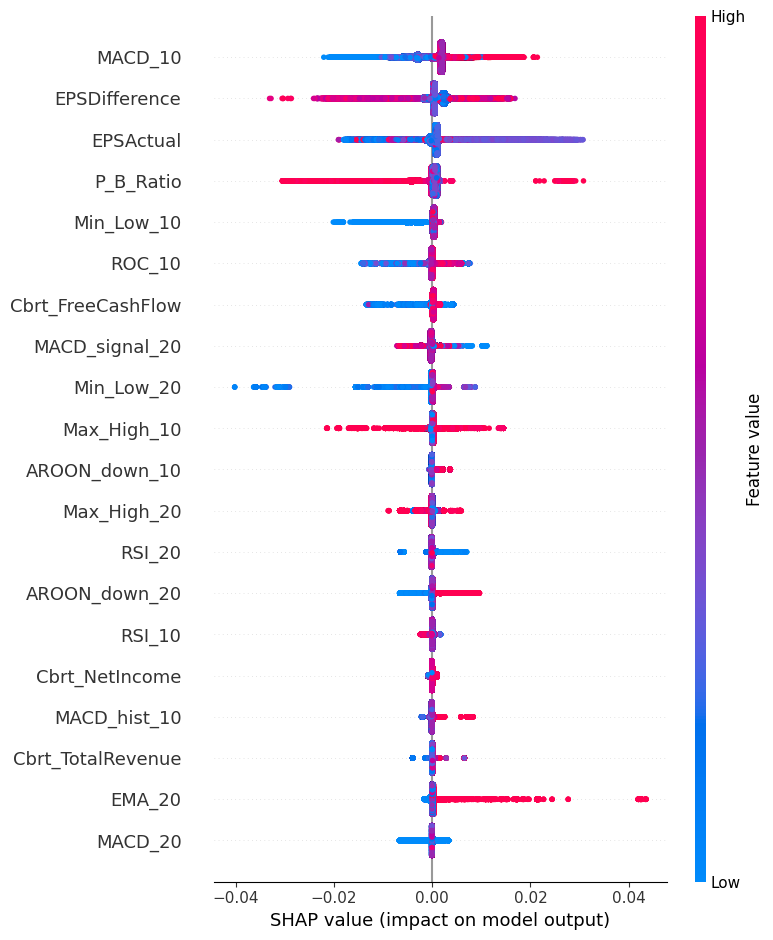

In [ ]:
explainer = shap.Explainer(model, test_X)
shap_values = explainer(test_X)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, test_X)


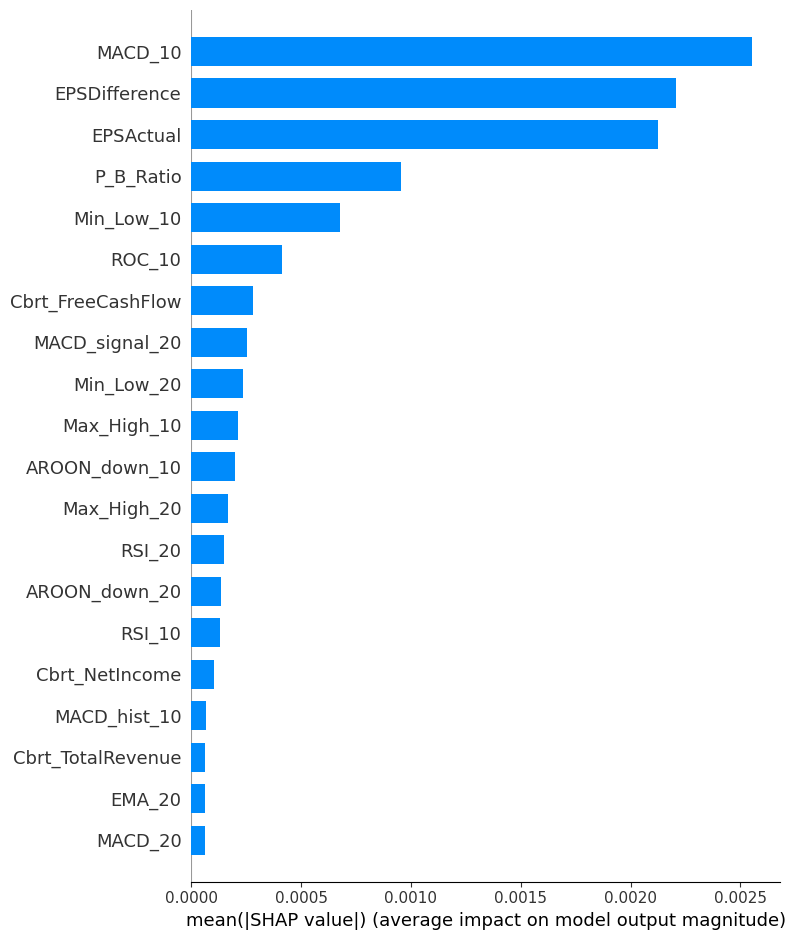

In [ ]:
shap.summary_plot(shap_values, test_X, plot_type="bar")

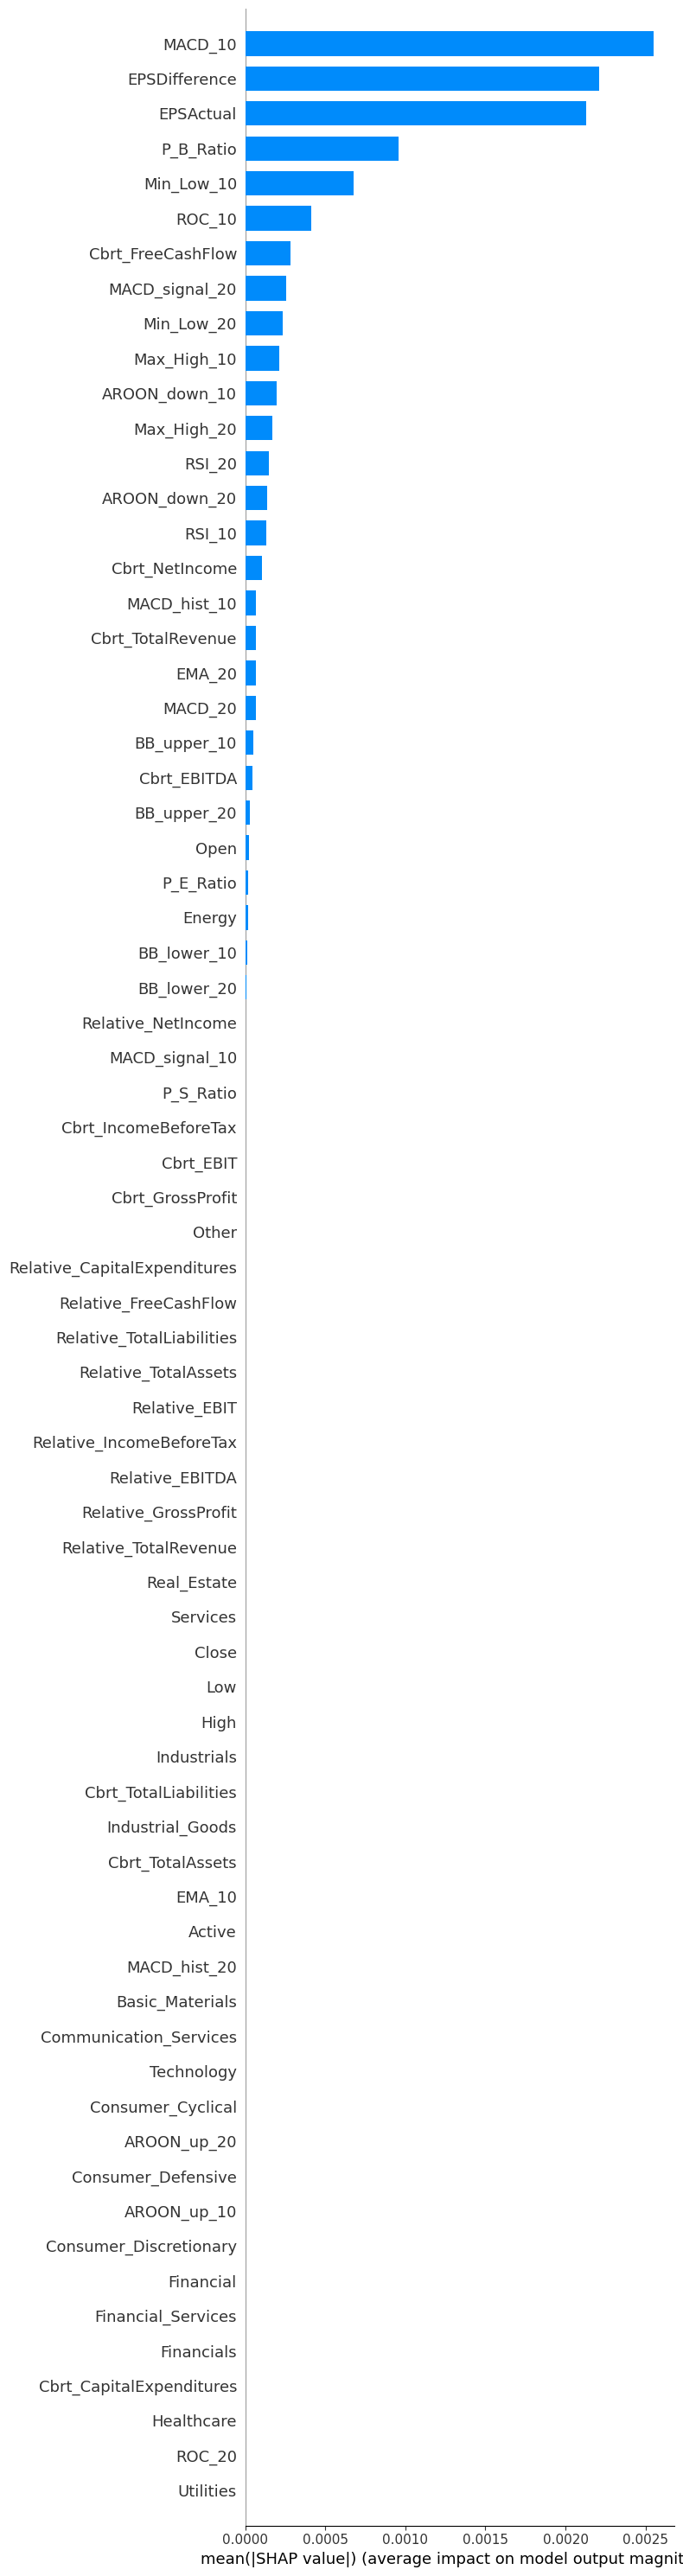

In [10]:
shap.summary_plot(shap_values, test_X, plot_type="bar", max_display=80)

In [ ]:
new_shap_values = explainer.shap_values(test_X)

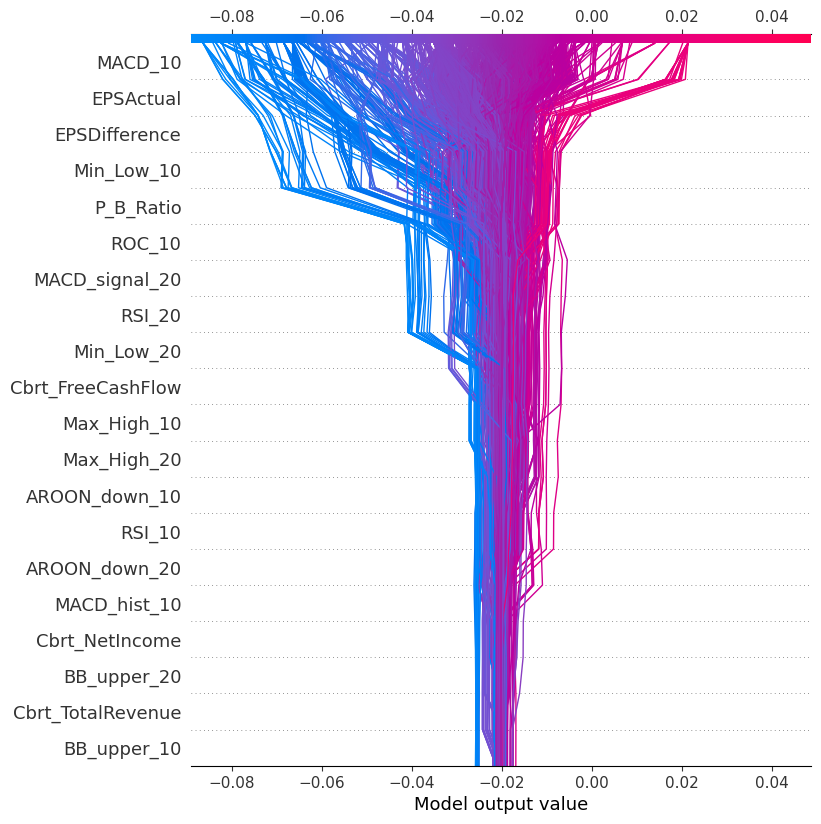

In [ ]:
shap.decision_plot(
    explainer.expected_value, 
    new_shap_values[:5000],         
    test_X.iloc[:5000],        
    ignore_warnings=True
)   


 98%|===================| 128872/130873 [00:32<00:00]        

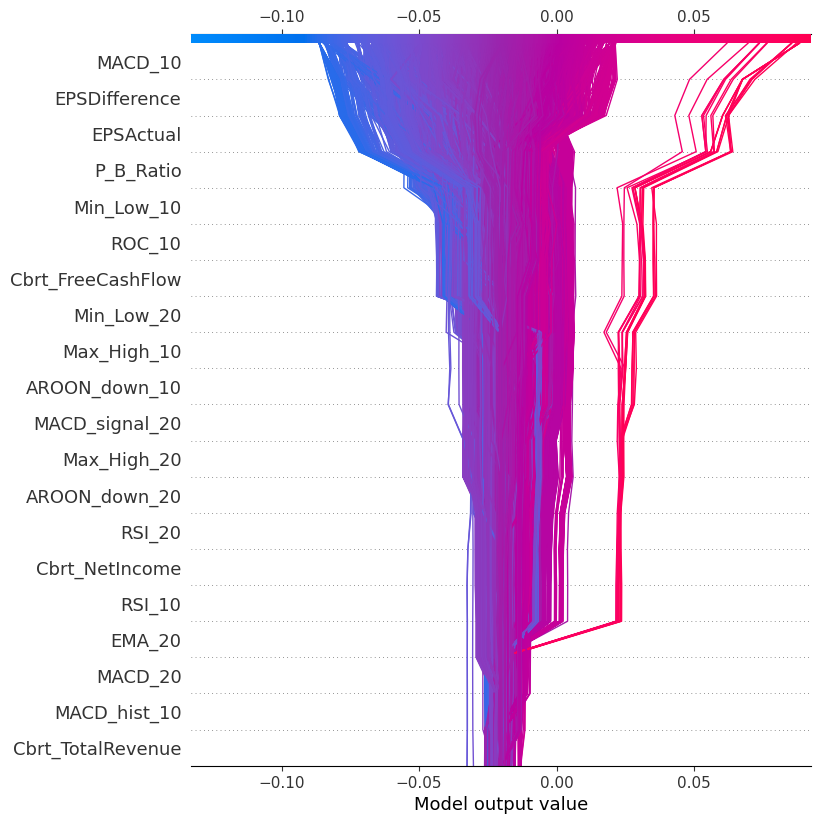

In [ ]:
new_test_X = test_df[test_df["target"] == 2].drop(columns=["Date", "Ticker", "target"]).reset_index(drop=True)
new_test_x = new_test_X.iloc[5000:10000]
new_shap_values = explainer.shap_values(new_test_X)

shap.decision_plot(
    explainer.expected_value,  
    new_shap_values,          
    new_test_X,          
    ignore_warnings=True
)   


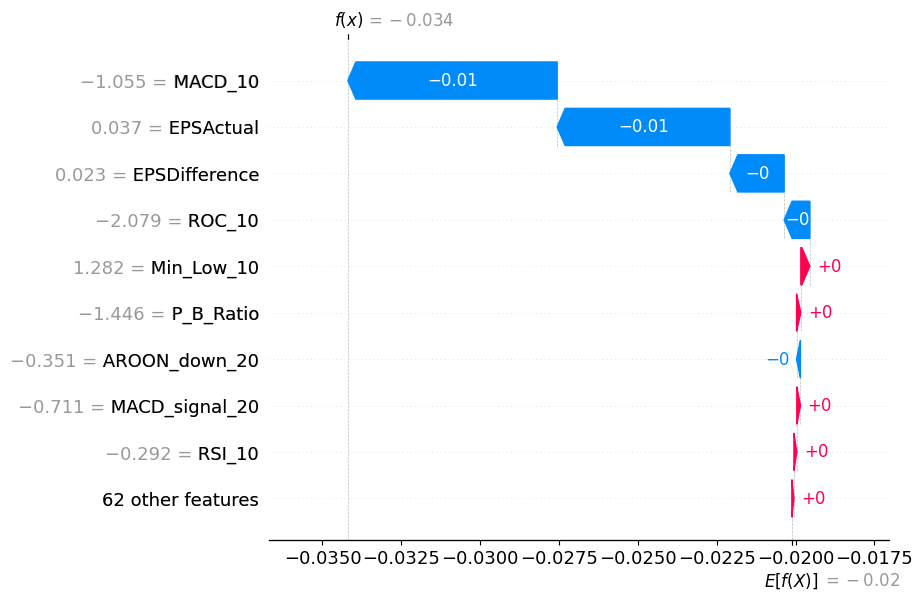

In [ ]:
shap.plots.waterfall(shap_values[1079])


In [18]:
aal_df = train_df[train_df["Ticker"] == "AAL"]
aal_df["target"].value_counts()

target
 0.0    2717
-2.0     757
 2.0     738
 1.0     394
-1.0     367
Name: count, dtype: int64

In [19]:
aal_df = test_df[test_df["Ticker"] == "AAL"]
aal_df["target"].value_counts()

target
-2.0    385
 2.0    318
-1.0    290
 1.0    220
 0.0    209
Name: count, dtype: int64